In [938]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_column', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_seq_items', 100)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [939]:
transaction_types = pd.read_csv('transaction_types.csv')
mcc_group_definition = pd.read_csv('mcc_group_definition.csv')
training_df = pd.read_csv('2016-09-19_79351_training.csv')

## Data Exploration

In [940]:
transaction_types.head(2)

,type,explanation,direction,agent
0,AR,Authorization reject,-,Card
1,AE,Authorization expired,In,Card


In [941]:
transaction_types.explanation.unique()

array(['Authorization reject', 'Authorization expired',
       'Authorization Reversal', 'Cash26 deposit', 'Credit Transfer',
       'Dispute', 'Debit Reversal', 'Credit Card refund by merchant',
       'Presentment Reversal', 'Referral payment', 'Authorized Action',
       'Cash26 withdrawal', 'Direct Debit', 'Debit Transfer',
       'MoneyBeam Transfer', 'Presentment', 'Transferwise Transaction',
       'Transferwise Transaction Reversal', 'Fee from N26',
       'Account Load', 'Account Unload', 'Card TX',
       'PT without Authorization'], dtype=object)

In [942]:
mcc_group_definition.head(2)

,mcc_group,explanation
0,1,ATM
1,2,Groceries


In [943]:
mcc_group_definition.explanation.unique()

array(['ATM', 'Groceries', 'Gastronomie', 'Shopping/(Fashion)',
       'Home and DIY, House Energy', 'Travel/Hotel', 'Transport',
       'Automotive/Gas', 'Family/Babies/Children',
       'Entertainment/Leisure', 'Drugstore', 'Finance', 'Insurance',
       'Taxes and Fines', 'Education', 'Miscellaneous',
       'Business Expenses'], dtype=object)

In [944]:
training_df.head(2)

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350,training,training
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202,training,training


In [945]:
training_df.transaction_date.min(), training_df.transaction_date.max()

('2016-02-01', '2016-07-31')

In [946]:
len(training_df), training_df.user_id.nunique()

(408546, 10000)

### Merge lookup tables

In [947]:
training_df = training_df.merge(transaction_types, left_on='transaction_type', right_on='type', how='left')
training_df = training_df.rename(columns={'explanation': 'transaction_type_explanation'})
training_df = training_df.merge(mcc_group_definition, on='mcc_group', how='left')
training_df = training_df.rename(columns={'explanation': 'mcc_group_explanation'})

In [948]:
all_df = training_df.copy()
all_df.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user,type,transaction_type_explanation,direction,agent,mcc_group_explanation
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350,training,training,DT,Debit Transfer,Out,Bank Account,NaN
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202,training,training,DT,Debit Transfer,Out,Bank Account,NaN
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,DT,NaN,291,training,training,DT,Debit Transfer,Out,Bank Account,NaN
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,DT,NaN,214,training,training,DT,Debit Transfer,Out,Bank Account,NaN
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,DT,NaN,272,training,training,DT,Debit Transfer,Out,Bank Account,NaN


## Load already created training and validation dataframe

In [949]:
# validation_set = all_df.user_id.sample(1000).tolist()
# validation_df = all_df[all_df.user_id.isin(validation_set)]
# training_df = all_df[~all_df.user_id.isin(validation_set)]

In [950]:
validation_df = pd.read_parquet('validation_df.parquet')
training_df = pd.read_parquet('training_df.parquet')

In [951]:
100*len(validation_df) / len(all_df), 100*len(training_df) / len(all_df)

(19.44040573154553, 80.55959426845448)

In [952]:
# validation_df.to_parquet('validation_df.parquet')
# training_df.to_parquet('training_df.parquet')

### Dropping redundant columns

In [953]:
training_df = training_df.drop(columns=['dataset_transaction', 'dataset_user', 'type', 'transaction_type', 'mcc_group'])
validation_df = validation_df.drop(columns=['dataset_transaction', 'dataset_user', 'type', 'transaction_type', 'mcc_group'])

### Check missing data

    We keep mcc_group_explanation due to less features and 64% of data being present.
    We cannot impute any mcc category for the missing values as the distribution is quite even.

In [954]:
training_df.isna().sum() / len(training_df)

user_id                         0.000000
transaction_date                0.000000
amount_n26_currency             0.000000
transaction_type_explanation    0.000000
direction                       0.000000
agent                           0.000000
mcc_group_explanation           0.365158
dtype: float64

In [955]:
training_df.mcc_group_explanation.value_counts(normalize=True)

mcc_group_explanation
ATM                           0.273326
Groceries                     0.194639
Travel/Hotel                  0.093983
Gastronomie                   0.080654
Shopping/(Fashion)            0.079338
Automotive/Gas                0.077390
Business Expenses             0.044807
Miscellaneous                 0.043582
Transport                     0.041710
Entertainment/Leisure         0.028683
Drugstore                     0.022198
Home and DIY, House Energy    0.013128
Finance                       0.003580
Education                     0.001278
Family/Babies/Children        0.001077
Insurance                     0.000536
Taxes and Fines               0.000091
Name: proportion, dtype: float64

### Imputation - When category frequency in column in less than 1% - replace category value with OTHER

In [956]:
training_df.columns

Index(['user_id', 'transaction_date', 'amount_n26_currency',
       'transaction_type_explanation', 'direction', 'agent',
       'mcc_group_explanation'],
      dtype='object')

In [957]:
categorical_cols = ['transaction_type_explanation', 'direction', 'agent', 'mcc_group_explanation']

for col in categorical_cols:
    temp = training_df[col].value_counts(normalize=True).reset_index()
    rows = temp[temp.proportion < 0.01][col].unique()
    training_df[col] = np.where(training_df[col].isin(rows), 'OTHER', training_df[col])
    validation_df[col] = np.where(validation_df[col].isin(rows), 'OTHER', validation_df[col])

# Insights

### Total Expenditure and Income

In [958]:
stats = training_df.copy()
stats['total_amount'] = stats['amount_n26_currency']
stats['mean_amount'] = stats['amount_n26_currency']

In [959]:
stats.groupby('direction').agg({'total_amount': 'sum'}).reset_index()

,direction,total_amount
0,In,8117902
1,Out,9101540


### Mean Expenditure and Income

In [960]:
stats.groupby(['direction']).agg({'mean_amount': 'mean'}).reset_index()

,direction,mean_amount
0,In,136.527111
1,Out,33.751534


### Add some of the many date features

In [961]:
stats['transaction_date'] = pd.to_datetime(stats['transaction_date'])
stats['transaction_weekday'] = stats['transaction_date'].dt.weekday
stats['transaction_weekday'] = stats['transaction_weekday'].apply(lambda x: calendar.day_name[x])
stats['transaction_month'] = stats['transaction_date'].dt.month
stats['transaction_year'] = stats['transaction_date'].dt.year
stats['transaction_day'] = stats['transaction_date'].dt.day

### Trend over weekdays

<Axes: xlabel='transaction_weekday', ylabel='total_amount'>

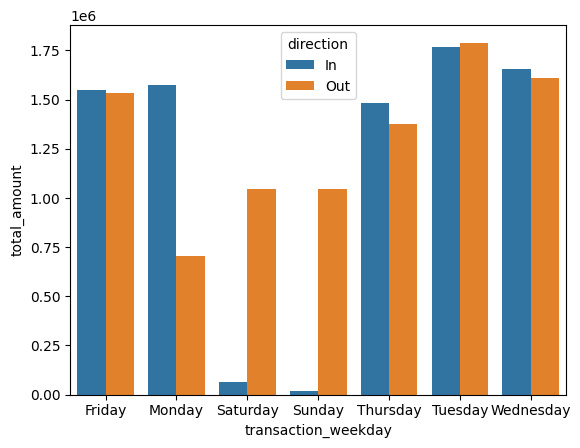

In [962]:
sns.barplot(x="transaction_weekday", y="total_amount", hue='direction', data=stats.groupby(['direction', 'transaction_weekday']).agg({'total_amount': 'sum'}).reset_index())


<Axes: xlabel='transaction_weekday', ylabel='mean_amount'>

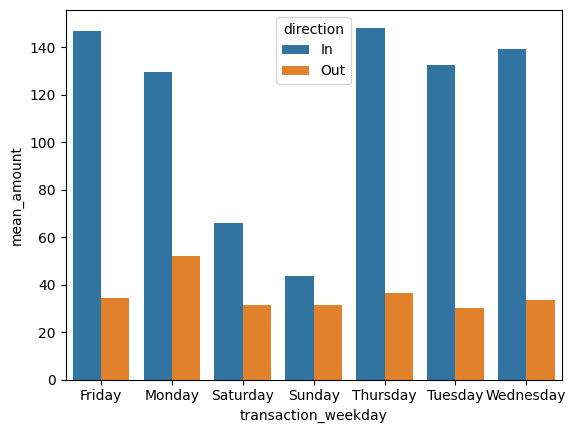

In [963]:
sns.barplot(x="transaction_weekday", y="mean_amount", hue='direction', data=stats.groupby(['direction', 'transaction_weekday']).agg({'mean_amount': 'mean'}).reset_index())


### Trend over months

<Axes: xlabel='transaction_month', ylabel='total_amount'>

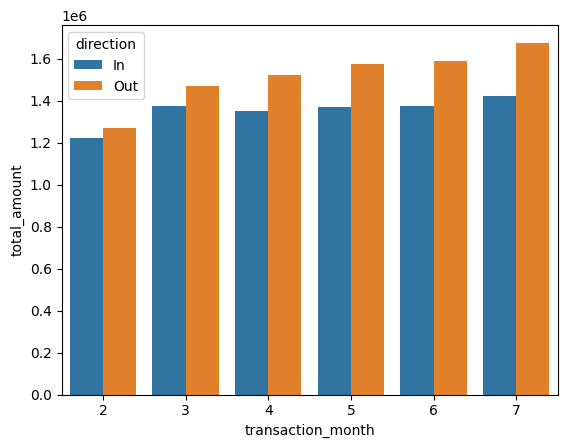

In [964]:
sns.barplot(x="transaction_month", y="total_amount", hue='direction', data=stats.groupby(['direction', 'transaction_month']).agg({'total_amount': 'sum'}).reset_index())


<Axes: xlabel='transaction_month', ylabel='mean_amount'>

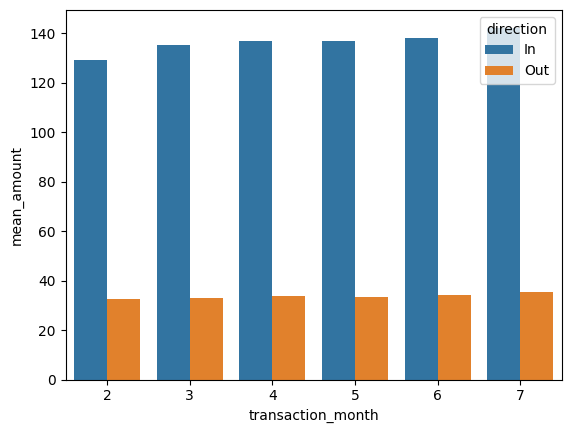

In [965]:
sns.barplot(x="transaction_month", y="mean_amount", hue='direction', data=stats.groupby(['direction', 'transaction_month']).agg({'mean_amount': 'mean'}).reset_index())


### Total Spend per mcc cateogry

<Axes: xlabel='total_amount', ylabel='mcc_group_explanation'>

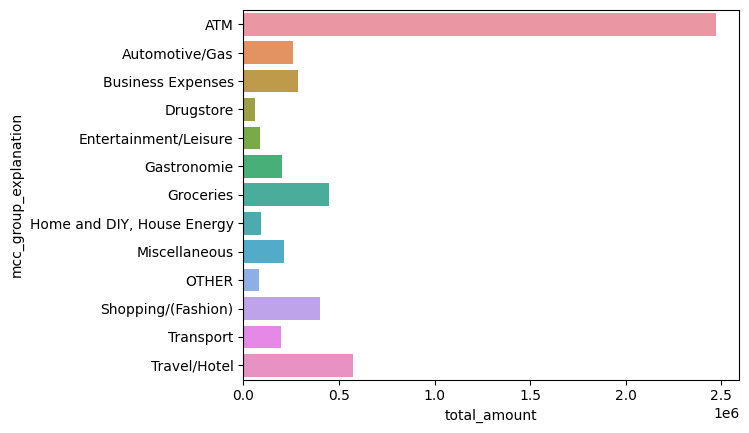

In [966]:
sns.barplot(x="total_amount", y="mcc_group_explanation", data=stats.groupby('mcc_group_explanation').agg({'total_amount': 'sum'}).reset_index())

### Average Spend per mcc cateogry

<Axes: xlabel='mean_amount', ylabel='mcc_group_explanation'>

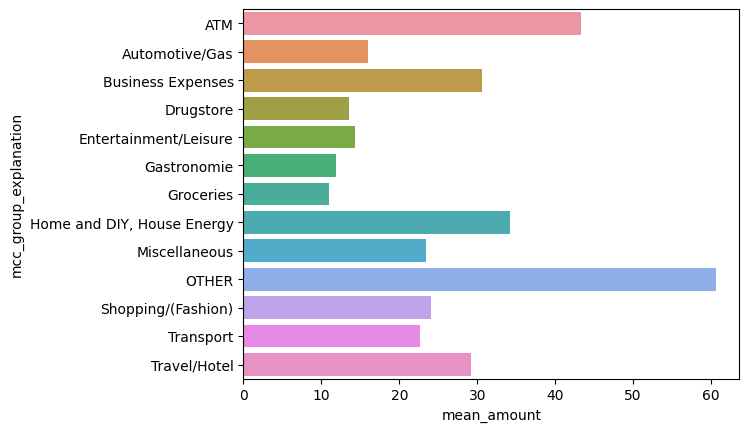

In [967]:
sns.barplot(x="mean_amount", y="mcc_group_explanation", data=stats.groupby('mcc_group_explanation').agg({'mean_amount': 'mean'}).reset_index())

### Income sources

<Axes: xlabel='total_amount', ylabel='transaction_type_explanation'>

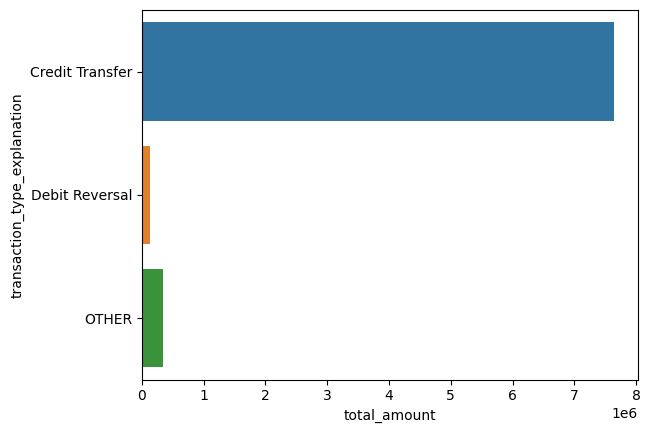

In [968]:
sns.barplot(x="total_amount", y="transaction_type_explanation", data=stats[stats.direction == 'In'].groupby(['transaction_type_explanation']).agg({'total_amount': 'sum'}).reset_index())


<Axes: xlabel='mean_amount', ylabel='transaction_type_explanation'>

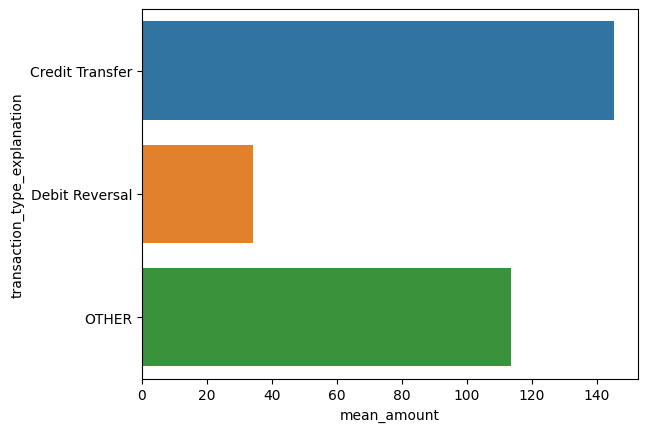

In [969]:
sns.barplot(x="mean_amount", y="transaction_type_explanation", data=stats[stats.direction == 'In'].groupby(['transaction_type_explanation']).agg({'mean_amount': 'mean'}).reset_index())


### Expenditure mediums

<Axes: xlabel='total_amount', ylabel='transaction_type_explanation'>

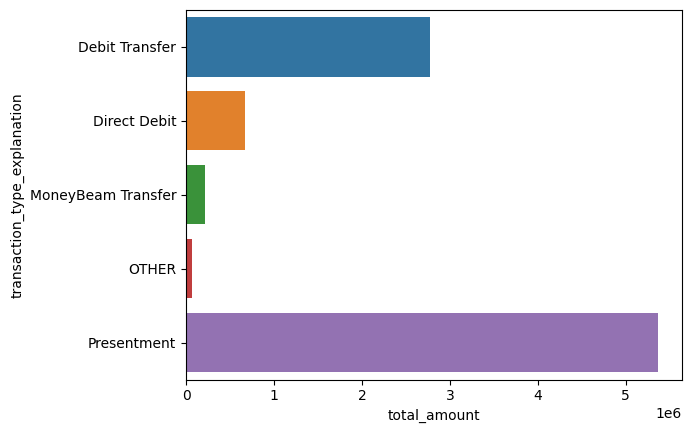

In [970]:
sns.barplot(x="total_amount", y="transaction_type_explanation", data=stats[stats.direction == 'Out'].groupby(['transaction_type_explanation']).agg({'total_amount': 'sum'}).reset_index())


<Axes: xlabel='mean_amount', ylabel='transaction_type_explanation'>

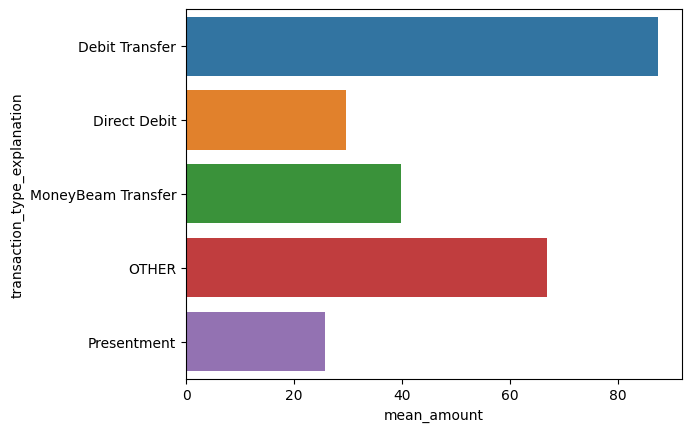

In [971]:
sns.barplot(x="mean_amount", y="transaction_type_explanation", data=stats[stats.direction == 'Out'].groupby(['transaction_type_explanation']).agg({'mean_amount': 'mean'}).reset_index())


## RFM Analysis

In [972]:
rfm_stats = training_df.copy()
from datetime import datetime
last_date = datetime(2016, 7, 31)

rfm_stats['transaction_date'] = rfm_stats['transaction_date'].astype(str)
rfm_stats['amount_n26_currency'] = rfm_stats['amount_n26_currency'].astype(str)
rfm_stats['recency'] = rfm_stats['transaction_date']
rfm_stats['frequency'] = rfm_stats['transaction_date'] + '_' + rfm_stats['amount_n26_currency']
rfm_stats['amount_n26_currency'] = rfm_stats['amount_n26_currency'].astype(int)
rfm_stats['monetary'] = rfm_stats['amount_n26_currency']

In [973]:
RFM_table = rfm_stats.groupby(['direction', 'user_id']).agg({'recency': lambda x: (last_date - pd.to_datetime(x.max())).days, # Recency
                                                            'frequency': lambda x: len(x.unique()), # Frequency
                                                            'monetary': lambda x: x.sum()}) # Monetary

In [974]:
RFM_table.head()

recency  frequency  monetary
direction user_id                                                       
In        000295594379774ab9ac2c78c946d615       58          4       942
          0011103fe4ba1264342882b7ab98c641       11          6      2083
          001e72a2f4c4376f10011735dde39cd5      130          3       426
          001f9baedaf3c8487c344d25b0eda9fc       58          6       241
          002244240e165748694a06f8cce13e6d        3          5       118

In [975]:
inRFM_table = RFM_table.loc[(RFM_table.index.get_level_values('direction') == 'In')]
outRFM_table = RFM_table.loc[(RFM_table.index.get_level_values('direction') == 'Out')]

In [976]:
RFM_table.shape, outRFM_table.shape

((17038, 3), (8788, 3))

In [977]:
quantiles = outRFM_table.quantile(q=[0.25,0.5,0.75])
quantiles.to_dict()

{'recency': {0.25: 2.0, 0.5: 11.0, 0.75: 44.0},
 'frequency': {0.25: 5.0, 0.5: 16.0, 0.75: 41.0},
 'monetary': {0.25: 124.0, 0.5: 442.0, 0.75: 1264.25}}

In [978]:
def lower_is_better(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
def higher_is_better(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
outRFM_table['R_Quartile'] = outRFM_table['recency'].apply(lower_is_better, args=('recency',quantiles,))
outRFM_table['F_Quartile'] = outRFM_table['frequency'].apply(higher_is_better, args=('frequency',quantiles,))
outRFM_table['M_Quartile'] = outRFM_table['monetary'].apply(higher_is_better, args=('monetary',quantiles,))

outRFM_table['outRFMClass'] = outRFM_table.R_Quartile.map(str) \
                            + outRFM_table.F_Quartile.map(str) \
                            + outRFM_table.M_Quartile.map(str)

/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/595611895.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outRFM_table['R_Quartile'] = outRFM_table['recency'].apply(lower_is_better, args=('recency',quantiles,))
/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/595611895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outRFM_table['F_Quartile'] = outRFM_table['frequency'].apply(higher_is_better, args=('frequency',quantiles,))
/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0

In [979]:
# Best users (outRFMClass = 444)
outRFM_table[outRFM_table['outRFMClass']=='444'].sort_values('monetary', ascending=False).head(5)

recency  frequency  monetary  \
direction user_id                                                          
Out       31a7c5c18a16e1671a6d6737800d2eb5        1        256     26195   
          f247e06970775cd2cf9cc906c0f4fadd        0        236     22231   
          afd08fece801491076cb3687548dae4d        1        176     20760   
          8f0b82e5e0584fb1ea765b1add9aed8b        0         44     18775   
          b25a79a65dfec20ad0470747d7c4037c        0        115     17593   

                                            R_Quartile  F_Quartile  \
direction user_id                                                    
Out       31a7c5c18a16e1671a6d6737800d2eb5           4           4   
          f247e06970775cd2cf9cc906c0f4fadd           4           4   
          afd08fece801491076cb3687548dae4d           4           4   
          8f0b82e5e0584fb1ea765b1add9aed8b           4           4   
          b25a79a65dfec20ad0470747d7c4037c           4           4   

                                            M_Quartile outRFMClass  
direction user_id                                                   
Out       31a7c5c18a16e1671a6d6737800d2eb5           4         444  
          f247e06970775cd2cf9cc906c0f4fadd           4         444  
          afd08fece801491076cb3687548dae4d           4         444  
          8f0b82e5e0584fb1ea765b1add9aed8b           4         444  
          b25a79a65dfec20ad0470747d7c4037c           4         444

In [980]:
# Dormant users (R_Quartile = 1)
outRFM_table[outRFM_table['R_Quartile'] <= 1].sort_values('monetary', ascending=False).head(5)

recency  frequency  monetary  \
direction user_id                                                          
Out       19b6a55d840e10a426f4df955d959d43       50         92     10688   
          dc3c755777898940adf9387e11e5fae5       52         28      8976   
          14ebb3ab44ccfb053ea4b155171a67e2       51         70      8850   
          6664005b965aa827871b1ecc226d7452       57         51      7730   
          f3eae82af7d3f91d5d7a8f334bfd8f3c       54        130      6981   

                                            R_Quartile  F_Quartile  \
direction user_id                                                    
Out       19b6a55d840e10a426f4df955d959d43           1           4   
          dc3c755777898940adf9387e11e5fae5           1           3   
          14ebb3ab44ccfb053ea4b155171a67e2           1           4   
          6664005b965aa827871b1ecc226d7452           1           4   
          f3eae82af7d3f91d5d7a8f334bfd8f3c           1           4   

                                            M_Quartile outRFMClass  
direction user_id                                                   
Out       19b6a55d840e10a426f4df955d959d43           4         144  
          dc3c755777898940adf9387e11e5fae5           4         134  
          14ebb3ab44ccfb053ea4b155171a67e2           4         144  
          6664005b965aa827871b1ecc226d7452           4         144  
          f3eae82af7d3f91d5d7a8f334bfd8f3c           4         144

In [981]:
# Users acquired but not retained (outRFMClass = 111)
outRFM_table[outRFM_table['outRFMClass']=='111'].sort_values('recency',ascending=False).head(5)

recency  frequency  monetary  \
direction user_id                                                          
Out       e5ddd856771465b7de1f5ad2a8aab445      181          1        38   
          f00cfb5925c98fc56bbaedd63eaa1ade      181          1         7   
          6b56eb6121797fbc0ae9899a41cc3c49      181          1        15   
          f7b8a2704150b93169d1b3e76298bc96      181          1        50   
          1de96bcf932c12b61cff6c522bd194d5      180          1        30   

                                            R_Quartile  F_Quartile  \
direction user_id                                                    
Out       e5ddd856771465b7de1f5ad2a8aab445           1           1   
          f00cfb5925c98fc56bbaedd63eaa1ade           1           1   
          6b56eb6121797fbc0ae9899a41cc3c49           1           1   
          f7b8a2704150b93169d1b3e76298bc96           1           1   
          1de96bcf932c12b61cff6c522bd194d5           1           1   

                                            M_Quartile outRFMClass  
direction user_id                                                   
Out       e5ddd856771465b7de1f5ad2a8aab445           1         111  
          f00cfb5925c98fc56bbaedd63eaa1ade           1         111  
          6b56eb6121797fbc0ae9899a41cc3c49           1         111  
          f7b8a2704150b93169d1b3e76298bc96           1         111  
          1de96bcf932c12b61cff6c522bd194d5           1         111

In [982]:
# Loyal customers (F_Quartile >= 3)
outRFM_table[outRFM_table['F_Quartile'] >= 3 ].sort_values('monetary', ascending=False).head(5)

recency  frequency  monetary  \
direction user_id                                                          
Out       31a7c5c18a16e1671a6d6737800d2eb5        1        256     26195   
          f247e06970775cd2cf9cc906c0f4fadd        0        236     22231   
          afd08fece801491076cb3687548dae4d        1        176     20760   
          6b8db259e00afca6bf439f1b9f47a4cf        7        157     19071   
          8f0b82e5e0584fb1ea765b1add9aed8b        0         44     18775   

                                            R_Quartile  F_Quartile  \
direction user_id                                                    
Out       31a7c5c18a16e1671a6d6737800d2eb5           4           4   
          f247e06970775cd2cf9cc906c0f4fadd           4           4   
          afd08fece801491076cb3687548dae4d           4           4   
          6b8db259e00afca6bf439f1b9f47a4cf           3           4   
          8f0b82e5e0584fb1ea765b1add9aed8b           4           4   

                                            M_Quartile outRFMClass  
direction user_id                                                   
Out       31a7c5c18a16e1671a6d6737800d2eb5           4         444  
          f247e06970775cd2cf9cc906c0f4fadd           4         444  
          afd08fece801491076cb3687548dae4d           4         444  
          6b8db259e00afca6bf439f1b9f47a4cf           4         344  
          8f0b82e5e0584fb1ea765b1add9aed8b           4         444

In [983]:
# Affluent customers (M_Quartile >= 3)
outRFM_table[outRFM_table['M_Quartile'] >= 3 ].sort_values('frequency', ascending=False).head(5)

recency  frequency  monetary  \
direction user_id                                                          
Out       ea1aa5473d0523a3534386eb2c779c2c        0        284      6736   
          de7ea8416132fc9ef76f474258c88a17        0        282     10497   
          107d4b66985b517efbba8b52cd4d5170        0        280     15096   
          03e14ca2ea8a6fe54d8ce70b4515fd41        0        274     12443   
          099bd270637e5ffa6c6a3e754567af93        0        272      9131   

                                            R_Quartile  F_Quartile  \
direction user_id                                                    
Out       ea1aa5473d0523a3534386eb2c779c2c           4           4   
          de7ea8416132fc9ef76f474258c88a17           4           4   
          107d4b66985b517efbba8b52cd4d5170           4           4   
          03e14ca2ea8a6fe54d8ce70b4515fd41           4           4   
          099bd270637e5ffa6c6a3e754567af93           4           4   

                                            M_Quartile outRFMClass  
direction user_id                                                   
Out       ea1aa5473d0523a3534386eb2c779c2c           4         444  
          de7ea8416132fc9ef76f474258c88a17           4         444  
          107d4b66985b517efbba8b52cd4d5170           4         444  
          03e14ca2ea8a6fe54d8ce70b4515fd41           4         444  
          099bd270637e5ffa6c6a3e754567af93           4         444

In [990]:
# Potentially excellent but Risky customers (M_Quartile >= 3 and F_Quartile <= 2 and R_Quartile <= 2)
outRFM_table[(outRFM_table['M_Quartile'] >= 4) & (outRFM_table['F_Quartile'] <= 1) & (outRFM_table['R_Quartile'] > 2)].sort_values('frequency', ascending=False).head(5)

recency  frequency  monetary  \
direction user_id                                                          
Out       146fe866c9e43136efedd53f3daf89e4        4          5      3345   
          be6784f84c24e69cdee906746c73d570        0          4      1426   

                                            R_Quartile  F_Quartile  \
direction user_id                                                    
Out       146fe866c9e43136efedd53f3daf89e4           3           1   
          be6784f84c24e69cdee906746c73d570           4           1   

                                            M_Quartile outRFMClass  
direction user_id                                                   
Out       146fe866c9e43136efedd53f3daf89e4           4         314  
          be6784f84c24e69cdee906746c73d570           4         414

## Feature Engineering

### Load data again

In [633]:
training_df = pd.read_parquet('training_df.parquet')
validation_df = pd.read_parquet('validation_df.parquet')

training_df = training_df.drop(columns=['dataset_transaction', 'dataset_user', 'type', 'transaction_type', 'mcc_group'])
validation_df = validation_df.drop(columns=['dataset_transaction', 'dataset_user', 'type', 'transaction_type', 'mcc_group'])
categorical_cols = ['transaction_type_explanation', 'direction', 'agent', 'mcc_group_explanation']

for col in categorical_cols:
    temp = training_df[col].value_counts(normalize=True).reset_index()
    rows = temp[temp.proportion < 0.01][col].unique()
    training_df[col] = np.where(training_df[col].isin(rows), 'OTHER', training_df[col])
    validation_df[col] = np.where(validation_df[col].isin(rows), 'OTHER', validation_df[col])
validation_df.shape, training_df.shape

((79423, 7), (329123, 7))

In [634]:
training_df.columns

Index(['user_id', 'transaction_date', 'amount_n26_currency',
       'transaction_type_explanation', 'direction', 'agent',
       'mcc_group_explanation'],
      dtype='object')

#### Compute and Get Features (Date Features, Transactional Features, Categorical Features)

In [898]:
from joblib import dump, load

def get_features(training_df, train, skip_categorical):
    training_df['transaction_date'] = pd.to_datetime(training_df['transaction_date'])
    training_df['transaction_weekday'] = training_df['transaction_date'].dt.weekday
    training_df['transaction_weekday'] = training_df['transaction_weekday'].apply(lambda x: calendar.day_name[x])
    training_df['transaction_month'] = training_df['transaction_date'].dt.month
    training_df['transaction_year'] = training_df['transaction_date'].dt.year
    training_df['transaction_day'] = training_df['transaction_date'].dt.day
    
    training_df['time_of_month'] = ''
    training_df['time_of_month'] = np.where(training_df['transaction_day'] <= 10, 'early_month', training_df['time_of_month'])
    training_df['time_of_month'] = np.where((training_df['transaction_day'] > 10) & (training_df['transaction_day'] <= 20), 'middle_month', training_df['time_of_month'])
    training_df['time_of_month'] = np.where(training_df['transaction_day'] > 20, 'end_month', training_df['time_of_month'])

    user_txn_features = pd.DataFrame()
    income_stats = training_df[training_df.direction == 'In'].groupby(['user_id']).agg({'direction': 'count', 'amount_n26_currency': 'sum'}).reset_index().rename(columns={'direction': 'total_incoming_activity', 'amount_n26_currency': 'total_incoming_value'})
    spend_stats = training_df[training_df.direction == 'Out'].groupby(['user_id']).agg({'direction': 'count', 'amount_n26_currency': 'sum'}).reset_index().rename(columns={'direction': 'total_spend_activity', 'amount_n26_currency': 'total_spend_value'})
    total_activity = training_df.groupby(['user_id']).agg({'direction': 'count', 'amount_n26_currency': 'sum'}).reset_index().rename(columns={'direction': 'total_activity', 'amount_n26_currency': 'total_value'})
    user_txn_features = pd.concat([user_txn_features, total_activity],axis=1)
    user_txn_features = user_txn_features.merge(spend_stats, how='left')
    user_txn_features = user_txn_features.merge(income_stats, how='left')
    user_txn_features.fillna(0, inplace=True)

    user_txn_features['total_spend_ratio'] = user_txn_features['total_spend_activity'] / user_txn_features['total_activity']
    user_txn_features['total_income_ratio'] = user_txn_features['total_incoming_activity'] / user_txn_features['total_activity']
    user_txn_features['income_to_spend_ratio'] = user_txn_features['total_incoming_activity'] / user_txn_features['total_spend_activity']

    user_txn_features = user_txn_features.drop(columns=['total_spend_value', 'total_incoming_value', 'total_value'])
    user_txn_features.fillna(0, inplace=True)

    ### Features removed due to leakage
    
    # incoming_outgoing = training_df.groupby(['user_id', 'direction', 'time_of_month']).amount_n26_currency.sum().reset_index()
    # txn_out = incoming_outgoing[incoming_outgoing.direction == 'Out'].pivot_table('amount_n26_currency', ['user_id'], 'time_of_month').reset_index().fillna(0).rename(columns={'early_month': 'Out_early_month',
    #                                                                                                                                                   'end_month': 'Out_end_month',
    #                                                                                                                                                   'middle_month': 'Out_middle_month'})
    
    # incoming_outgoing = training_df.groupby(['user_id', 'direction', 'time_of_month']).amount_n26_currency.sum().reset_index()
    # txn_in = incoming_outgoing[incoming_outgoing.direction == 'In'].pivot_table('amount_n26_currency', ['user_id'], 'time_of_month').reset_index().fillna(0).rename(columns={'early_month': 'In_early_month',
    #                                                                                                                                                   'end_month': 'In_end_month',
    #                                                                                                                                                   'middle_month': 'In_middle_month'})

    # user_txn_features = user_txn_features.merge(txn_in, how='left')
    # user_txn_features = user_txn_features.merge(txn_out, how='left')
    # user_txn_features.fillna(0, inplace=True)

    # incoming_outgoing = training_df.groupby(['user_id', 'direction', 'transaction_weekday']).amount_n26_currency.sum().reset_index()
    # txn_out = incoming_outgoing[incoming_outgoing.direction == 'Out'].pivot_table('amount_n26_currency', ['user_id'], 'transaction_weekday').reset_index().fillna(0)
    
    # txn_out.columns = ['user_id'] +['Out_' + col_name for col_name in txn_out.columns if 'user_id' != col_name]
    # incoming_outgoing = training_df.groupby(['user_id', 'direction', 'transaction_weekday']).amount_n26_currency.sum().reset_index()
    # txn_in = incoming_outgoing[incoming_outgoing.direction == 'In'].pivot_table('amount_n26_currency', ['user_id'], 'transaction_weekday').reset_index().fillna(0)
    # txn_in.columns = ['user_id'] +['In_' + col_name for col_name in txn_in.columns if 'user_id' != col_name]
    
    # user_txn_features = user_txn_features.merge(txn_in, how='left')
    # user_txn_features = user_txn_features.merge(txn_out, how='left')
    # user_txn_features.fillna(0, inplace=True)

    latest = training_df[training_df.direction == 'Out'].groupby(['user_id']).transaction_date.max().reset_index().rename(columns={'transaction_date': 'latest_date_expenditure'})
    earliest = training_df[training_df.direction == 'Out'].groupby(['user_id']).transaction_date.min().reset_index().rename(columns={'transaction_date': 'earliest_date_expenditure'})
    user_platform_age = latest.merge(earliest)
    user_platform_age['user_expenditure_platform_age'] = (user_platform_age['latest_date_expenditure'] - user_platform_age['earliest_date_expenditure']).dt.days
    latest = training_df[training_df.direction == 'In'].groupby(['user_id']).transaction_date.max().reset_index().rename(columns={'transaction_date': 'latest_date_income'})
    earliest = training_df[training_df.direction == 'In'].groupby(['user_id']).transaction_date.min().reset_index().rename(columns={'transaction_date': 'earliest_date_income'})
    temp = latest.merge(earliest)
    user_platform_age = user_platform_age.merge(temp, how='left')
    user_platform_age['user_income_platform_age'] = (user_platform_age['latest_date_income'] - user_platform_age['earliest_date_income']).dt.days
    user_platform_age = user_platform_age[['user_id', 'user_expenditure_platform_age', 'user_income_platform_age']]
    user_platform_age.user_income_platform_age.fillna(round(user_platform_age.user_income_platform_age.mean()), inplace=True)
    user_txn_features = user_txn_features.merge(user_platform_age, how='left')
    
    stats = training_df[['user_id', 'direction', 'transaction_date']]
    stats['transaction_rate'] = stats.groupby(['user_id', 'direction']).transaction_date.diff()
    stats['transaction_rate'] = stats['transaction_rate'].dt.days
    stats['transaction_rate'].fillna(0, inplace=True)
    transaction_rate = stats.pivot_table('transaction_rate', ['user_id'], 'direction').reset_index().fillna(0).rename(columns={'In': 'In_transaction_rate',
                                                                                                                                 'Out': 'Out_transaction_rate'})
    user_txn_features = user_txn_features.merge(transaction_rate, how='left')
    
    stats = training_df[['user_id', 'direction', 'amount_n26_currency', 'transaction_date']]
    stats['transaction_date'] = pd.to_datetime(stats['transaction_date'])
    stats = stats.reset_index(drop=True)
    def cumulative_time(x):
        return 1 + (x - x.min()).dt.days
    time_cumulative = stats.groupby(['user_id', 'direction'])['transaction_date'].apply(cumulative_time).reset_index().drop(columns=['level_2'])
    txn_cumulative = stats.groupby(['user_id', 'direction'])['amount_n26_currency'].apply(pd.Series.cumsum).reset_index().drop(columns=['level_2'])
    
    cumulative_txns = pd.concat([txn_cumulative, time_cumulative], axis=1)
    cumulative_txns = cumulative_txns.iloc[:,2:]
    cumulative_txns['spend_per_day'] = cumulative_txns['amount_n26_currency'] / cumulative_txns['transaction_date']
    cumulative_txns = cumulative_txns.pivot_table('spend_per_day', ['user_id'], 'direction').reset_index().fillna(0).rename(columns={'In': 'Income_per_day',
                                                                                                                                     'Out': 'Spend_per_day'})
    
    user_txn_features = user_txn_features.merge(cumulative_txns, how='left')
    user_txn_features.fillna(0, inplace=True)
    
    for col in user_txn_features.columns:
        if len(user_txn_features[user_txn_features[col] == np.inf]) != 0:
            user_txn_features[col] = np.where(user_txn_features[col] == np.inf, 0, user_txn_features[col])

    if skip_categorical:
        return user_txn_features
        
    categorical_cols = ['transaction_type_explanation', 'agent', 'mcc_group_explanation']
    categorical_data = training_df[categorical_cols]
    
    if train:
        ohe = OneHotEncoder(categories='auto', handle_unknown='ignore')
        feature_arr = ohe.fit_transform(categorical_data).toarray()
        dump(ohe, f'OHE.pkl')
    else:
        ohe = load(f'OHE.pkl')
        feature_arr = ohe.transform(categorical_data).toarray()

    feature_arr = ohe.fit_transform(categorical_data).toarray()
    ohe_labels = ohe.get_feature_names_out(categorical_cols)
    ohe_features = pd.DataFrame(feature_arr, columns=ohe_labels)
    
    ohe_features = training_df[['user_id']].join(ohe_features)
    ohe_features = ohe_features.groupby('user_id').sum().reset_index()
    user_txn_features = user_txn_features.merge(ohe_features, how='left')
    user_txn_features.fillna(0, inplace=True)

    return user_txn_features
    

In [643]:
train = get_features(training_df, train=True)

/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/917986365.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats['transaction_rate'] = stats.groupby(['user_id', 'direction']).transaction_date.diff()
/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/917986365.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats['transaction_rate'] = stats['transaction_rate'].dt.days
/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/917986365.py:77: SettingWithCopyWarni

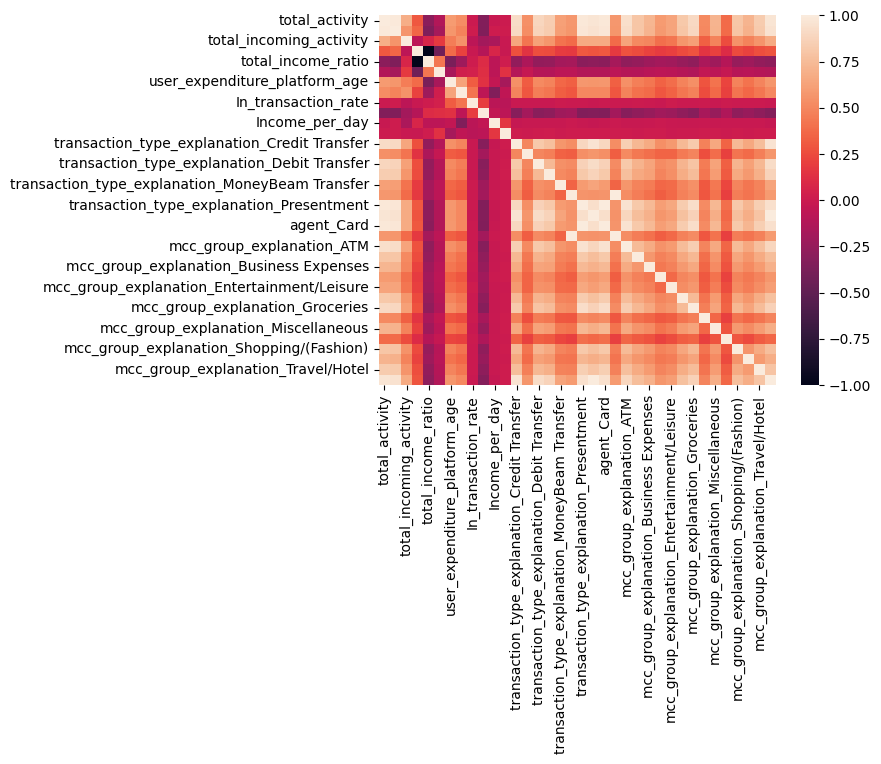

In [922]:
corr = train.drop(columns=['user_id']).corr()
sns.heatmap(corr)
plt.show()

### Scaling Features

In [923]:
train = get_features(training_df, train=True, skip_categorical=False)
cols = train.drop(columns=['user_id', 'clusters'], errors='ignore').columns.tolist()
data = train[cols]

/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/1169026568.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats['transaction_rate'] = stats.groupby(['user_id', 'direction']).transaction_date.diff()
/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/1169026568.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats['transaction_rate'] = stats['transaction_rate'].dt.days
/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/1169026568.py:74: SettingWithCopyWa

In [924]:
scaler = StandardScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns=cols)

### Kmeans clusters

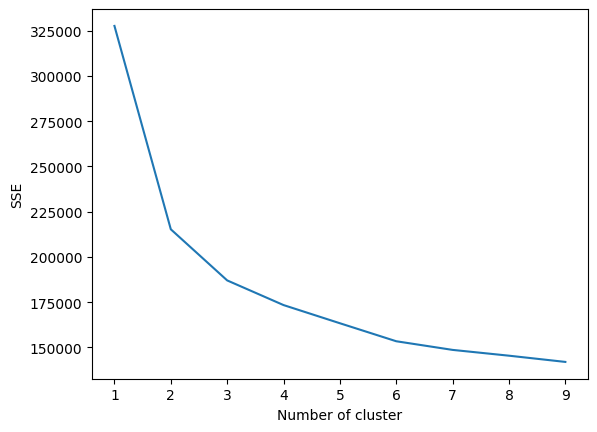

In [925]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(data)
    data["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### Check Kmeans model scores

In [926]:
model = KMeans(n_clusters=3, random_state= 7)
model.fit(data.drop(columns=['user_id', 'clusters'], errors='ignore'))

KMeans(n_clusters=3, random_state=7)

In [929]:
test = get_features(validation_df, train=False, skip_categorical=False)

/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/1169026568.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats['transaction_rate'] = stats.groupby(['user_id', 'direction']).transaction_date.diff()
/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/1169026568.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats['transaction_rate'] = stats['transaction_rate'].dt.days
/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/1169026568.py:74: SettingWithCopyWa

In [930]:
test = test[cols]
scaler = StandardScaler()
data = scaler.fit_transform(test.drop(columns=['user_id'], errors='ignore'))
data = pd.DataFrame(data, columns=cols)

In [933]:
model.inertia_

186390.39970227398

In [934]:
model.score(data)

-23772.478260334745

### Conclusion: Kmeans does not create good clusters for us

## Regression

In [914]:
train = get_features(training_df, train=True, skip_categorical=False)
test = get_features(validation_df, train=False, skip_categorical=False)

X_train = train.copy()
y_train = training_df[['user_id', 'direction', 'amount_n26_currency']].groupby(['user_id', 'direction']).agg({'amount_n26_currency': 'sum'}).reset_index()

X_test = test.copy()
y_test = validation_df[['user_id', 'direction', 'amount_n26_currency']].groupby(['user_id', 'direction']).agg({'amount_n26_currency': 'sum'}).reset_index()

/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/1169026568.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats['transaction_rate'] = stats.groupby(['user_id', 'direction']).transaction_date.diff()
/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/1169026568.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats['transaction_rate'] = stats['transaction_rate'].dt.days
/var/folders/7v/9m4nyvsx4d1b9m1n9y_plznr0000gn/T/ipykernel_10476/1169026568.py:74: SettingWithCopyWa

# Modeling and Performance

In [915]:
from xgboost import XGBRegressor
seed = 88
xgb = XGBRegressor(random_state = seed)
model = xgb

## Model for expenditure

In [916]:
# Filter data for users who have spent money
x = X_train[X_train.user_id.isin(y_train[y_train.direction == 'Out'].user_id)].drop(columns=['user_id'])
y = y_train[y_train.direction == 'Out'].drop(columns=['user_id', 'direction'])

model.fit(x, y)

prediction = model.predict(X_test.drop(columns=['user_id']))

# metrics
y =  y_test[y_test.direction == 'Out'].drop(columns=['user_id', 'direction']).reset_index(drop=True)
mse = mean_squared_error(prediction,y)
rmse = np.sqrt(mse)
mse, rmse

(2458995.185551034, 1568.118358272434)

In [917]:
preds = pd.DataFrame(prediction)
preds = preds.join(y).rename(columns={0: 'prediction', 'amount_n26_currency': 'amount_spent'})
preds

,prediction,amount_spent
0,694.509094,706
1,4734.618164,5687
2,2230.673340,2793
3,756.419678,375
4,3536.251221,4040
...,...,...
894,5068.207520,5616
895,2059.480225,875
896,2102.198486,1885
897,87.246933,54


In [918]:
xgb = XGBRegressor(random_state = seed)
model = xgb

# Filter data for users who have spent money
x = X_train[X_train.user_id.isin(y_train[y_train.direction == 'In'].user_id)].drop(columns=['user_id'])
y = y_train[y_train.direction == 'In'].drop(columns=['user_id', 'direction'])

# Fit
model.fit(x, y)

x = X_test[X_test.user_id.isin(y_test[y_test.direction == 'In'].user_id)].drop(columns=['user_id'])
y = y_test[y_test.direction == 'In'].drop(columns=['user_id', 'direction'])

# Predict
prediction = model.predict(x)

# metrics
mse = mean_squared_error(prediction, y)
rmse = np.sqrt(mse)
mse, rmse

(1485909.9365426304, 1218.9790550057169)

In [919]:
preds = pd.DataFrame(prediction)
preds = preds.join(y_test[y_test.direction == 'In'].drop(columns=['user_id', 'direction']).reset_index(drop=True)).rename(columns={0: 'prediction', 'amount_n26_currency': 'amount_spent'})
preds

,prediction,amount_spent
0,440.241821,815
1,3853.912842,5392
2,1896.079834,1762
3,1444.034790,574
4,3198.659668,4332
...,...,...
883,4468.168457,2746
884,2767.325439,1177
885,1973.639893,3351
886,172.978378,93


### Best Features

In [935]:
xgb.feature_importances_

array([0.34511018, 0.01233465, 0.12773712, 0.0146904 , 0.        ,
       0.03118791, 0.01552186, 0.0271943 , 0.01086137, 0.00845662,
       0.07115596, 0.13622193, 0.00873873, 0.00558033, 0.00766971,
       0.01080797, 0.01024904, 0.00798757, 0.0086916 , 0.01245302,
       0.        , 0.        , 0.01068998, 0.00932282, 0.0077079 ,
       0.00919498, 0.0094385 , 0.01119405, 0.01068074, 0.00611371,
       0.00786715, 0.0071165 , 0.0078911 , 0.01266141, 0.00719103,
       0.01027986], dtype=float32)

<Axes: xlabel='importance', ylabel='feature'>

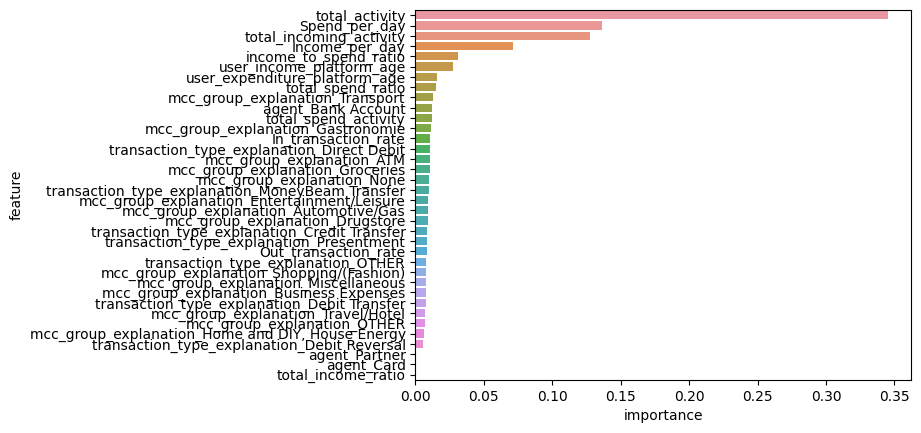

In [936]:
f_importances = pd.DataFrame(xgb.feature_importances_, columns=['importance'], index=X_test.drop(columns=['user_id']).columns).sort_values('importance',ascending=False).reset_index().rename(columns={'index': 'feature'})
sns.barplot(data=f_importances, x='importance', y='feature')


<Axes: xlabel='importance', ylabel='feature'>

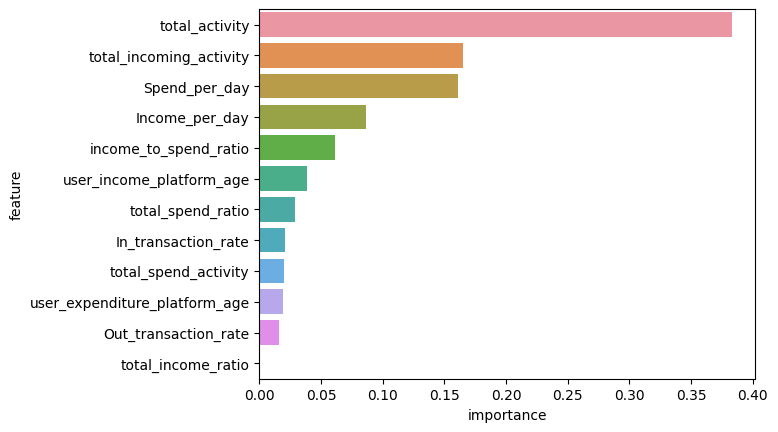

In [913]:
f_importances = pd.DataFrame(xgb.feature_importances_, columns=['importance'], index=X_test.drop(columns=['user_id']).columns).sort_values('importance',ascending=False).reset_index().rename(columns={'index': 'feature'})
sns.barplot(data=f_importances, x='importance', y='feature')
